In [1]:
from collections import defaultdict
import os
import pickle as pkl
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qml
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from tqdm import tqdm

import seaborn as sns

# Define helper functions
- borrow code from Chemprop

In [2]:
def str_to_mol(string, explicit_hydrogens=False):
    """
    Converts an InChI or SMILES string to an RDKit molecule.

    :param string: The InChI or SMILES string.
    :param explicit_hydrogens: Whether to treat hydrogens explicitly.
    :return: The RDKit molecule.
    """
    RDKIT_SMILES_PARSER_PARAMS = Chem.SmilesParserParams()
    if string.startswith('InChI'):
        mol = Chem.MolFromInchi(string, removeHs=not explicit_hydrogens)
    else:
        # Set params here so we don't remove hydrogens with atom mapping
        RDKIT_SMILES_PARSER_PARAMS.removeHs = not explicit_hydrogens
        mol = Chem.MolFromSmiles(string, RDKIT_SMILES_PARSER_PARAMS)

    if explicit_hydrogens:
        return Chem.AddHs(mol)
    else:
        return Chem.RemoveHs(mol)

In [3]:
def generate_scaffold(mol, include_chirality=False):
    """
    Compute the Bemis-Murcko scaffold for a SMILES string.

    :param mol: A smiles string or an RDKit molecule.
    :param include_chirality: Whether to include chirality.
    :return:
    """
    mol = str_to_mol(mol) if type(mol) == str else mol
    scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)

    return scaffold

In [4]:
def scaffold_to_smiles(mols,
                       use_indices=False):
    """
    Computes scaffold for each smiles string and returns a mapping from scaffolds to sets of smiles.

    :param mols: A list of smiles strings or RDKit molecules.
    :param use_indices: Whether to map to the smiles' index in all_smiles rather than mapping
    to the smiles string itself. This is necessary if there are duplicate smiles.
    :return: A dictionary mapping each unique scaffold to all smiles (or smiles indices) which have that scaffold.
    """
    scaffolds = defaultdict(set)
    for i, mol in tqdm(enumerate(mols), total=len(mols)):
        scaffold = generate_scaffold(mol)
        if use_indices:
            scaffolds[scaffold].add(i)
        else:
            scaffolds[scaffold].add(mol)

    return scaffolds

In [5]:
# modify this function from Chemprop to just return the indices
def scaffold_split(mols,
                   sizes=(0.8, 0.1, 0.1),
                   balanced=False,
                   seed=0,
                   ):
    """
    Split a dataset by scaffold so that no molecules sharing a scaffold are in the same split.

    :param data: A MoleculeDataset or ReactionDataset.
    
    :param mols: a list of rdkit molecules
    
    :param sizes: A length-3 tuple with the proportions of data in the
    train, validation, and test sets.
    :param balanced: Try to balance sizes of scaffolds in each set, rather than just putting smallest in test set.
    :param seed: Seed for shuffling when doing balanced splitting.
    :param logger: A logger.
    :return: A tuple containing the train, validation, and test splits of the data.
    """
    assert sum(sizes) == 1

    # Split
    train_size, val_size, test_size = sizes[0] * len(mols), sizes[1] * len(mols), sizes[2] * len(mols)
    train, val, test = [], [], []
    train_scaffold_count, val_scaffold_count, test_scaffold_count = 0, 0, 0
    
    scaffold_to_indices = scaffold_to_smiles(mols, use_indices=True)

    if balanced:  # Put stuff that's bigger than half the val/test size into train, rest just order randomly
        index_sets = list(scaffold_to_indices.values())
        big_index_sets = []
        small_index_sets = []
        for index_set in index_sets:
            if len(index_set) > val_size / 2 or len(index_set) > test_size / 2:
                big_index_sets.append(index_set)
            else:
                small_index_sets.append(index_set)
        random.seed(seed)
        random.shuffle(big_index_sets)
        random.shuffle(small_index_sets)
        index_sets = big_index_sets + small_index_sets
    else:  # Sort from largest to smallest scaffold sets
        index_sets = sorted(list(scaffold_to_indices.values()),
                            key=lambda index_set: len(index_set),
                            reverse=True)

    for index_set in index_sets:
        if len(train) + len(index_set) <= train_size:
            train += index_set
            train_scaffold_count += 1
        elif len(val) + len(index_set) <= val_size:
            val += index_set
            val_scaffold_count += 1
        else:
            test += index_set
            test_scaffold_count += 1

    
    print(f'Total scaffolds = {len(scaffold_to_indices):,} | '
          f'train scaffolds = {train_scaffold_count:,} | '
          f'val scaffolds = {val_scaffold_count:,} | '
          f'test scaffolds = {test_scaffold_count:,}')
    
    return train, val, test

# Create Scaffold splits
- use 5 different random seeds

In [6]:
# use csv from Colin's published data so we have SMILES to create scaffold splits
df = pd.read_csv('data/GDB7-20-TS/wb97xd3_v1.0.1.csv')
df

,idx,rsmi,psmi,ea,dh
0,0,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([C:2]([N:3]=[O:4])=[N+:6]=[N-:5])([H:7])...,48.659484,25.845091
1,1,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([N:3]=[C:2]=[N:6][N:5]=[O:4])([H:7])([H:...,74.207878,25.357506
2,2,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]1([H:6])([H:7])[O:2][C:3]([H:9])([H:10])[...,102.656628,12.050720
3,3,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]([O:2][H:13])([H:6])([H:7])[H:8].[C:3]1([...,76.830279,22.023014
4,4,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]([O:2][H:13])([H:6])([H:7])[H:8].[C:3]([C...,72.185427,-4.896952
...,...,...,...,...,...
11956,11956,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C:2][C:4]([O:5][C:6](=[O:7])[H:15])([H:...,76.498542,71.925276
11957,11957,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C@@:2]1([H:11])[O:3][C@:6]([O:7][H:12])...,43.743167,6.397510
11958,11958,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C@@:2]([O:3][H:12])([C:4](=[O:5])[H:14]...,73.601660,27.552744
11959,11959,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1](=[C:2]([C:4]([O:5][C:6](=[O:7])[H:15])([...,66.621537,13.289960


In [7]:
mols = [str_to_mol(rsmi, explicit_hydrogens=True) for rsmi in df.rsmi]
len(mols)

11961

In [8]:
indices = []
for seed in range(5):
    
    train_indices, val_indices, test_indices = scaffold_split(mols,
                                                              sizes=(0.85, 0.05, 0.1),
                                                              balanced=True,
                                                              seed=seed)
    print(len(train_indices), len(val_indices), len(test_indices))
    indices.append([train_indices, val_indices, test_indices])

100%|██████████| 11961/11961 [00:00<00:00, 17709.90it/s]


Total scaffolds = 468 | train scaffolds = 381 | val scaffolds = 34 | test scaffolds = 53
10165 598 1198


100%|██████████| 11961/11961 [00:00<00:00, 18762.65it/s]


Total scaffolds = 468 | train scaffolds = 392 | val scaffolds = 23 | test scaffolds = 53
10165 597 1199


100%|██████████| 11961/11961 [00:00<00:00, 18013.97it/s]


Total scaffolds = 468 | train scaffolds = 350 | val scaffolds = 38 | test scaffolds = 80
10166 598 1197


100%|██████████| 11961/11961 [00:00<00:00, 17858.48it/s]


Total scaffolds = 468 | train scaffolds = 360 | val scaffolds = 31 | test scaffolds = 77
10165 598 1198


100%|██████████| 11961/11961 [00:00<00:00, 16602.31it/s]

Total scaffolds = 468 | train scaffolds = 365 | val scaffolds = 34 | test scaffolds = 69
10166 598 1197


In [9]:
with open('GDB7_scaffold_split_indices.pkl', 'wb') as f:
    pkl.dump(indices, f)

In [10]:
MAX_TRAIN_LENGTH = 10165
n_points = 5
train_fractions = np.logspace(-1, 0, num=n_points, endpoint=True)
train_sizes = [int(MAX_TRAIN_LENGTH * x) for x in train_fractions]
train_sizes

[1016, 1807, 3214, 5716, 10165]

Create indices to train Chemprop on

In [11]:
for train_size in train_sizes:
    folds = []
    for train, val, test in indices:
        train = train[:train_size]
        folds.append([train, val, test])
    with open(f'data/GDB7-20-TS/GDB7_scaffold_split_indices_train_size_{train_size}.pkl', 'wb') as f:
        pkl.dump(folds, f)

# Create inputs and train the model

In [12]:
from src.reaction_reps import QML, B2R2
from src.learning import predict_KRR

In [13]:
def polyfit(train_sizes, maes):
    m, c = np.polyfit(np.log(train_sizes), np.log(maes), 1)
    polyfit = np.exp(m * np.log(train_sizes) + c)
    return polyfit

In [14]:
start = time.time()
b2r2 = B2R2()
b2r2.get_gdb7_rxn_data()
print(f'Elapsed time: {time.time() - start:.1f} seconds')

Elapsed time: 7.9 seconds


In [15]:
energies = b2r2.barriers
pd.DataFrame(energies).describe()

,0
count,11961.000000
mean,83.392466
std,22.755110
min,10.727258
25%,67.287048
50%,81.519704
75%,97.646429
max,204.654825


In [16]:
# takes about 15 min when not pickled
filename = 'GDB7_b2r2_l.pkl'
if os.path.exists(f'{filename}'):
    with open(f'{filename}', 'rb') as f:
        b2r2_l = pkl.load(f)
else:
    start = time.time()
    b2r2_l = b2r2.get_b2r2_l(Rcut=6)
    with open(f'{filename}', 'wb') as f:
        pkl.dump(b2r2_l, f)
    print(f'Elapsed time: {time.time() - start:.1f} seconds')

In [17]:
start = time.time()
qml = QML()
qml.get_gdb7_rxn_data()
print(f'Elapsed time: {time.time() - start:.1f} seconds')

Elapsed time: 13.8 seconds


# Reproduce Figure 4 but use scaffold splits

In [18]:
start = time.time()
slatm_2_r, slatm_2_p, slatm_2_d = qml.get_SLATM_twobody()
print(f'Elapsed time: {time.time() - start:.1f} seconds')

Elapsed time: 161.8 seconds


Must use the hyperparameters that they report in the SI for the GDB7 dataset i.e. $\sigma = 10$ and $\lambda$ = 1e-4

In [19]:
start = time.time()
X = slatm_2_d
y = energies

CV = 5
n_points = 5
sigma = 10
l2reg = 1e-4

maes = np.zeros((CV, n_points))
preds = {i: [] for i in range(n_points)}
targets = {i: [] for i in range(n_points)}
    
for i, (train_idx, val_idx, test_idx) in enumerate(indices):
    print("CV iteration", i)
    
    X_train_i, X_test_i = X[train_idx], X[test_idx]
    y_train_i, y_test_i = y[train_idx], y[test_idx]
    
    train_sizes = [int(len(y_train_i) * x) for x in train_fractions]

    for j, train_size in enumerate(train_sizes):
        
        X_train = X_train_i[:train_size]
        y_train = y_train_i[:train_size]
        mae, y_pred = predict_KRR(
            X_train, X_test_i, y_train, y_test_i, sigma=sigma, l2reg=l2reg
        )
        preds[j].append(y_pred)
        targets[j].append(y_test_i)
        maes[i, j] = mae
print(f'Elapsed time: {time.time() - start:.1f} seconds')

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
Elapsed time: 671.3 seconds


In [20]:
train_sizes

[1016, 1807, 3214, 5716, 10166]

In [21]:
maes

array([[20.89728737, 18.99428547, 18.878847  , 11.92007179, 10.50307747],
       [24.51398142, 21.73811122, 21.16773284, 12.74722433, 10.25922202],
       [24.41331165, 22.79069511, 22.49145339, 13.93854172, 11.16492199],
       [29.85306716, 25.78814141, 25.96822288, 14.56642606, 12.56828217],
       [25.94596521, 23.56940741, 24.2652722 , 13.42862507, 10.53226049]])

Pickle the results

In [22]:
with open('GDB7_scaffold_splits_predictions.pkl', 'wb') as f:
    pkl.dump(preds, f)

In [23]:
with open('GDB7_scaffold_splits_targets.pkl', 'wb') as f:
    pkl.dump(targets, f)

In [24]:
with open('GDB7_scaffold_splits_maes.pkl', 'wb') as f:
    pkl.dump(maes, f)

Load the results

In [25]:
with open('GDB7_scaffold_splits_predictions.pkl', 'rb') as f:
    preds = pkl.load(f)

In [26]:
with open('GDB7_scaffold_splits_targets.pkl', 'rb') as f:
    targets = pkl.load(f)

In [27]:
with open('GDB7_scaffold_splits_maes.pkl', 'rb') as f:
    maes = pkl.load(f)

****************************************************************************************
training size had 1016 examples
test size was 1198
min: -112.05 kcal/mol	 max: 205.60 kcal/mol
mean: 4.58 kcal/mol	 std: 28.27 kcal/mol
****************************************************************************************
training size had 1016 examples
test size was 1199
min: -92.99 kcal/mol	 max: 205.60 kcal/mol
mean: 12.09 kcal/mol	 std: 31.75 kcal/mol
****************************************************************************************
training size had 1016 examples
test size was 1197
min: -97.11 kcal/mol	 max: 160.98 kcal/mol
mean: 9.54 kcal/mol	 std: 32.60 kcal/mol
****************************************************************************************
training size had 1016 examples
test size was 1198
min: -85.51 kcal/mol	 max: 168.86 kcal/mol
mean: 16.87 kcal/mol	 std: 36.78 kcal/mol
****************************************************************************************
training siz

Text(0.5, 0, 'Error (kcal/mol)')

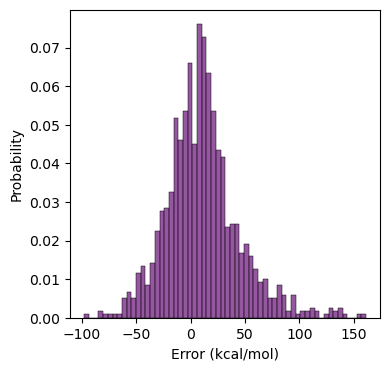

In [28]:
color = '#721f81'  # dark purple
ii = 0
f, ax = plt.subplots(figsize=(4, 4))
for pred, target in zip(preds[ii], targets[ii]):
    print('*'*88)
    print(f'training size had {train_sizes[ii]} examples')
    # make sure the testing size is the same 
    # assert train_sizes[ii] == len(pred)
    print(f'test size was {len(pred)}')
    residuals = target - pred.flatten()
    print(f'min: {np.min(residuals):.2f} kcal/mol\t max: {np.max(residuals):.2f} kcal/mol')
    print(f'mean: {np.mean(residuals):.2f} kcal/mol\t std: {np.std(residuals):.2f} kcal/mol')

# just plot a histogram for the last results
sns.histplot(residuals, 
             color=color,
             bins=60, stat='probability', edgecolor="k")

ax.set_xlabel('Error (kcal/mol)')

****************************************************************************************
training size had 10166 examples
test size was 1198
min: -50.13 kcal/mol	 max: 102.19 kcal/mol
mean: 1.27 kcal/mol	 std: 15.75 kcal/mol
****************************************************************************************
training size had 10166 examples
test size was 1199
min: -54.44 kcal/mol	 max: 66.07 kcal/mol
mean: 0.68 kcal/mol	 std: 14.63 kcal/mol
****************************************************************************************
training size had 10166 examples
test size was 1197
min: -77.79 kcal/mol	 max: 97.44 kcal/mol
mean: 0.18 kcal/mol	 std: 16.22 kcal/mol
****************************************************************************************
training size had 10166 examples
test size was 1198
min: -115.27 kcal/mol	 max: 77.63 kcal/mol
mean: -0.41 kcal/mol	 std: 17.75 kcal/mol
****************************************************************************************
training siz

Text(0.5, 0, 'Error (kcal/mol)')

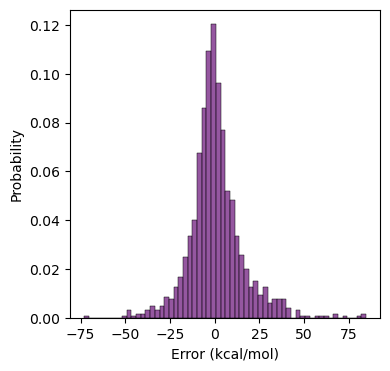

In [29]:
color = '#721f81'  # dark purple
ii = 4
f, ax = plt.subplots(figsize=(4, 4))
for pred, target in zip(preds[ii], targets[ii]):
    print('*'*88)
    print(f'training size had {train_sizes[ii]} examples')
    # make sure the testing size is the same 
    # assert train_sizes[ii] == len(pred)
    print(f'test size was {len(pred)}')
    residuals = target - pred.flatten()
    print(f'min: {np.min(residuals):.2f} kcal/mol\t max: {np.max(residuals):.2f} kcal/mol')
    print(f'mean: {np.mean(residuals):.2f} kcal/mol\t std: {np.std(residuals):.2f} kcal/mol')

# just plot a histogram for the last results
sns.histplot(residuals, 
             color=color,
             bins=60, stat='probability', edgecolor="k")

ax.set_xlabel('Error (kcal/mol)')

In [30]:
mae_slatm_2_d = np.mean(maes, axis=0)
std_slatm_2_d = np.std(maes, axis=0)

In [31]:
mae_slatm_2_d

array([25.12472256, 22.57612812, 22.55430566, 13.32017779, 11.00555283])

In [32]:
std_slatm_2_d

array([2.89074387, 2.23076405, 2.45021502, 0.92041751, 0.83678173])

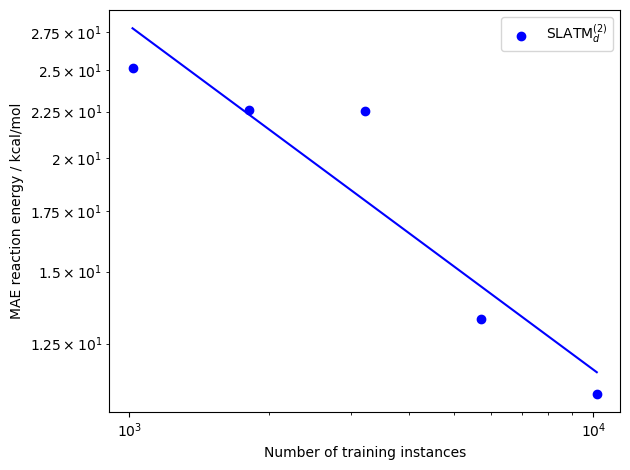

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xscale('log')
ax.set_yscale('log')

ax.scatter(train_sizes, mae_slatm_2_d, color='blue', label='SLATM$_d^{(2)}$')
ax.plot(train_sizes, polyfit(train_sizes, mae_slatm_2_d), color='blue')

ax.set_xlabel("Number of training instances")
ax.set_ylabel("MAE reaction energy / kcal/mol")
plt.legend()
plt.tight_layout()
plt.show()